In [74]:
import pandas as pd 
import seaborn as sns 
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.linear_model import LinearRegression , Ridge , Lasso
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split , RandomizedSearchCV , GridSearchCV , cross_val_score
import matplotlib.pyplot as plt
from xgboost import XGBClassifier , XGBRegressor
import numpy as np

In [75]:
df = pd.read_excel("premiums_young.xlsx")
df.shape

(20096, 13)

In [76]:
df.head(5)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712


In [77]:
df.columns = df.columns.str.replace(" " , "_").str.lower()
df.head(5)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712


In [78]:
df.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

### Handling NA values

In [79]:
df.dropna(inplace = True)
df.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

### Checking Duplicate values

In [80]:
df.duplicated().sum()

np.int64(0)

In [81]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267
std,2.294052,0.940713,23.420493,2749.906347
min,18.000000,-3.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


In [82]:
df[df.number_of_dependants < 0]["number_of_dependants"].unique()

array([-3, -1])

In [83]:
df["number_of_dependants"] = abs(df["number_of_dependants"])
df["number_of_dependants"].describe()

count    20090.000000
mean         0.722598
std          0.937200
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: number_of_dependants, dtype: float64

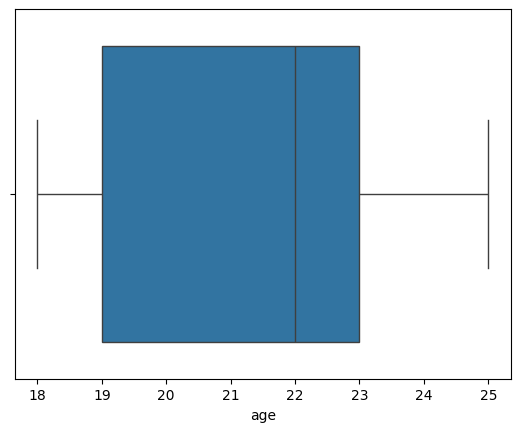

In [84]:
sns.boxplot(x = df['age'])
plt.show()

In [85]:
numeric_col = df.select_dtypes(['float64' , 'int64']).columns
numeric_col

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

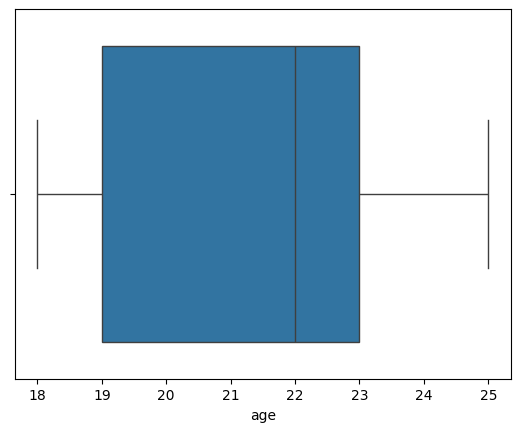

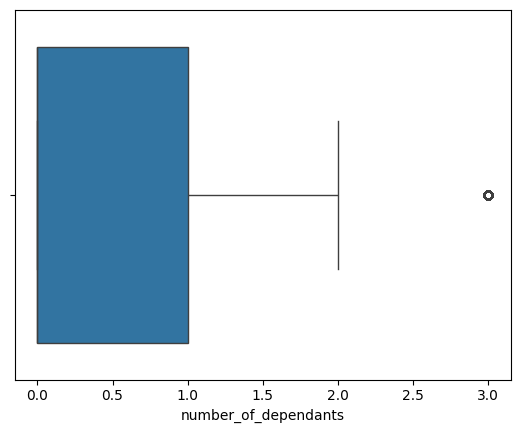

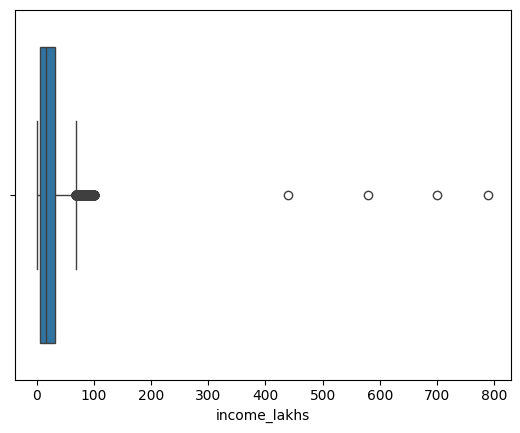

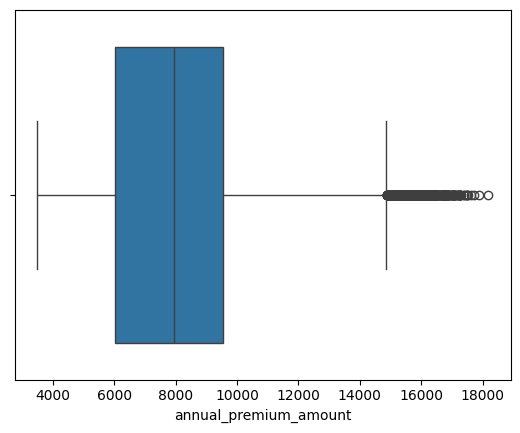

In [86]:
for col in numeric_col:
    sns.boxplot(x = df[col])
    plt.show()

In [87]:
df[df.age >100]["age"].unique()

array([], dtype=int64)

In [88]:
df1 = df[df.age <= 100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267
std,2.294052,0.937200,23.420493,2749.906347
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


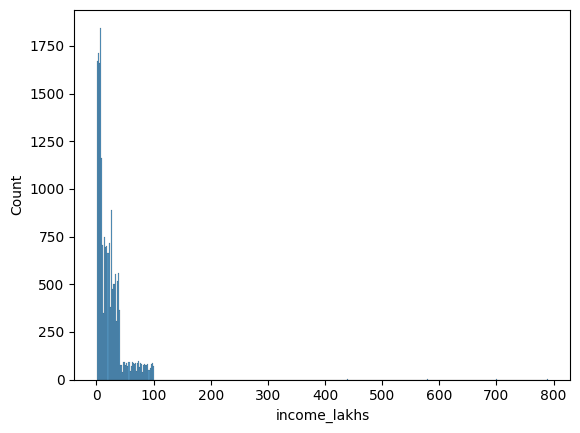

In [89]:
sns.histplot(df1.income_lakhs)
plt.show()

In [90]:
df1.income_lakhs.quantile([0.25 , 0.75])


0.25     6.0
0.75    31.0
Name: income_lakhs, dtype: float64

In [91]:
def get_iqr_bounds(col):
    Q1 , Q3 = col.quantile([0.25 , 0.75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    return lower_bound , upper_bound

In [92]:
get_iqr_bounds(df1.income_lakhs)

(-31.5, 68.5)

In [93]:
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

np.float64(100.0)

In [94]:
df2 = df1[df1.income_lakhs <= quantile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20086.000000,20086.000000,20086.000000,20086.000000
mean,21.494474,0.722742,22.390371,8141.799263
std,2.294248,0.937238,21.732062,2749.912486
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.000000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,100.000000,18186.000000


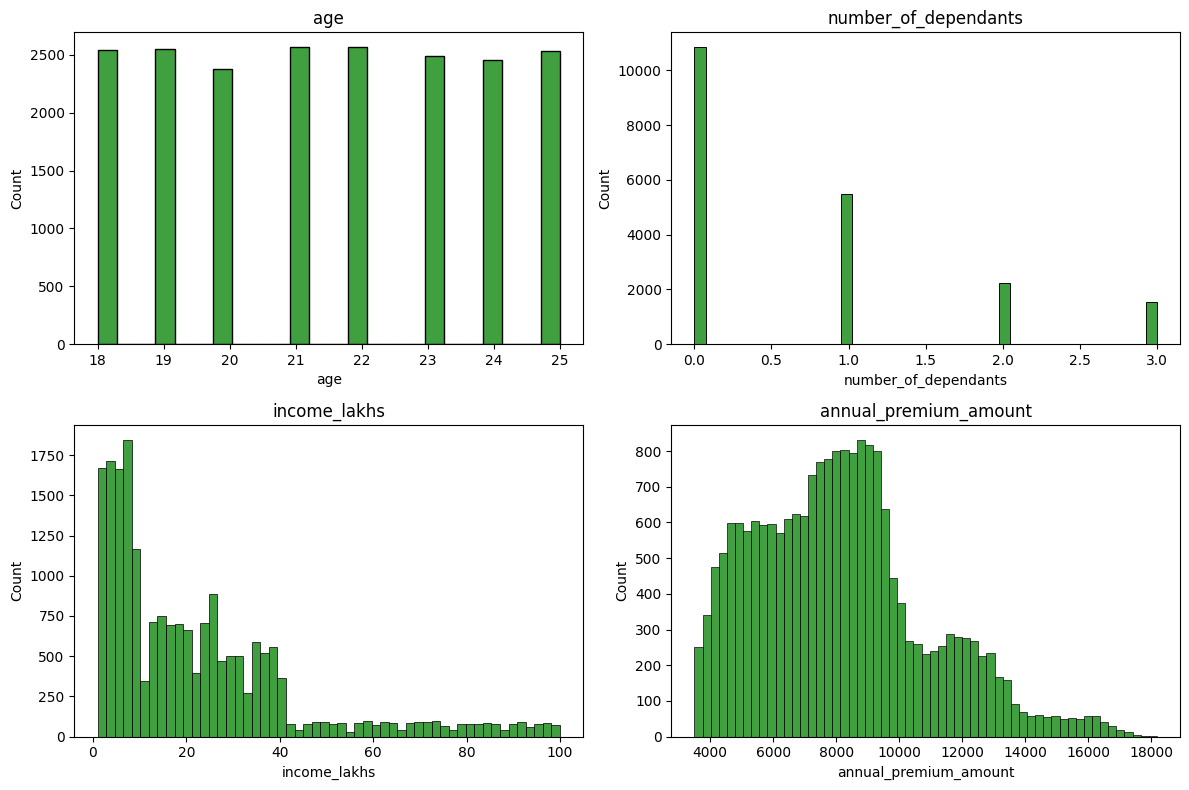

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(numeric_col[:4]):
    sns.histplot(
        df2[col],
        color="green",
        edgecolor="black",
        ax=axes[i]
    )
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

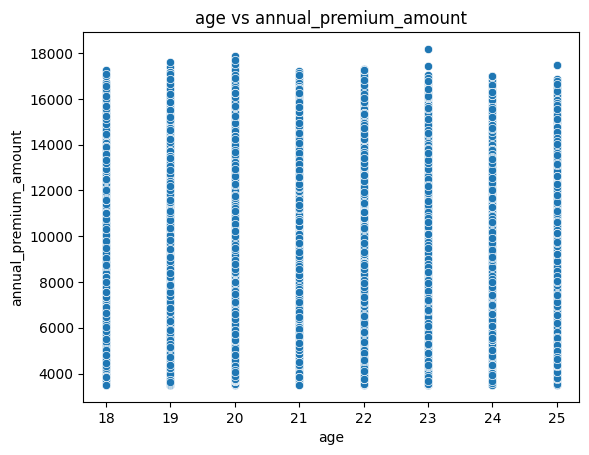

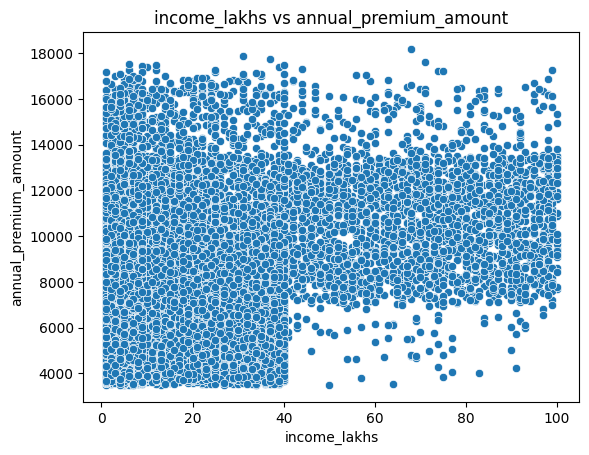

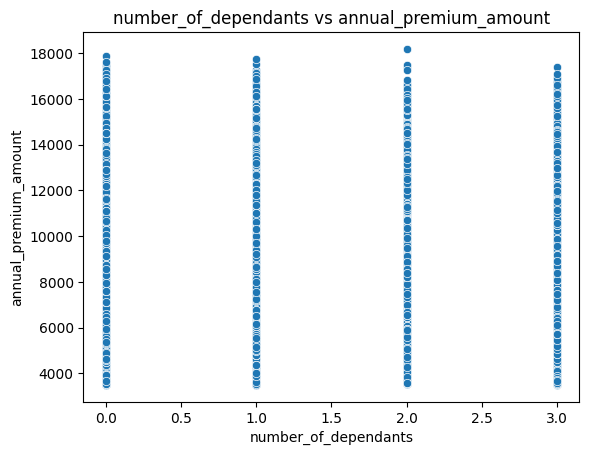

In [96]:
numeric_features = ["age" , "income_lakhs" , "number_of_dependants"]

for num in numeric_features:
    sns.scatterplot( x = df2[num]  , y= df2["annual_premium_amount"])
    plt.title(f"{num} vs annual_premium_amount")
    plt.xlabel(num)
    plt.ylabel("annual_premium_amount")
    plt.show()



In [97]:
categorical_col = df2.select_dtypes(['string' , 'object' ,'category']).columns
categorical_col

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [98]:
category_col = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan']

for cat in category_col:
    print(cat , ":" , df2[cat].unique())

gender : ['Male' 'Female']
region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status : ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan : ['Silver' 'Bronze' 'Gold']


In [99]:
df2["smoking_status"].replace({
    "Smoking=0": "No Smoking",
    "Does Not Smoke": "No Smoking",
    "Not Smoking": "No Smoking"
}, inplace=True)

df2["smoking_status"].unique()

C:\Users\sehaj\AppData\Local\Temp\ipykernel_24860\3325360402.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2["smoking_status"].replace({


array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

In [100]:
pct_count = df2["gender"].value_counts(normalize = True)
pct_count

gender
Male      0.550383
Female    0.449617
Name: proportion, dtype: float64

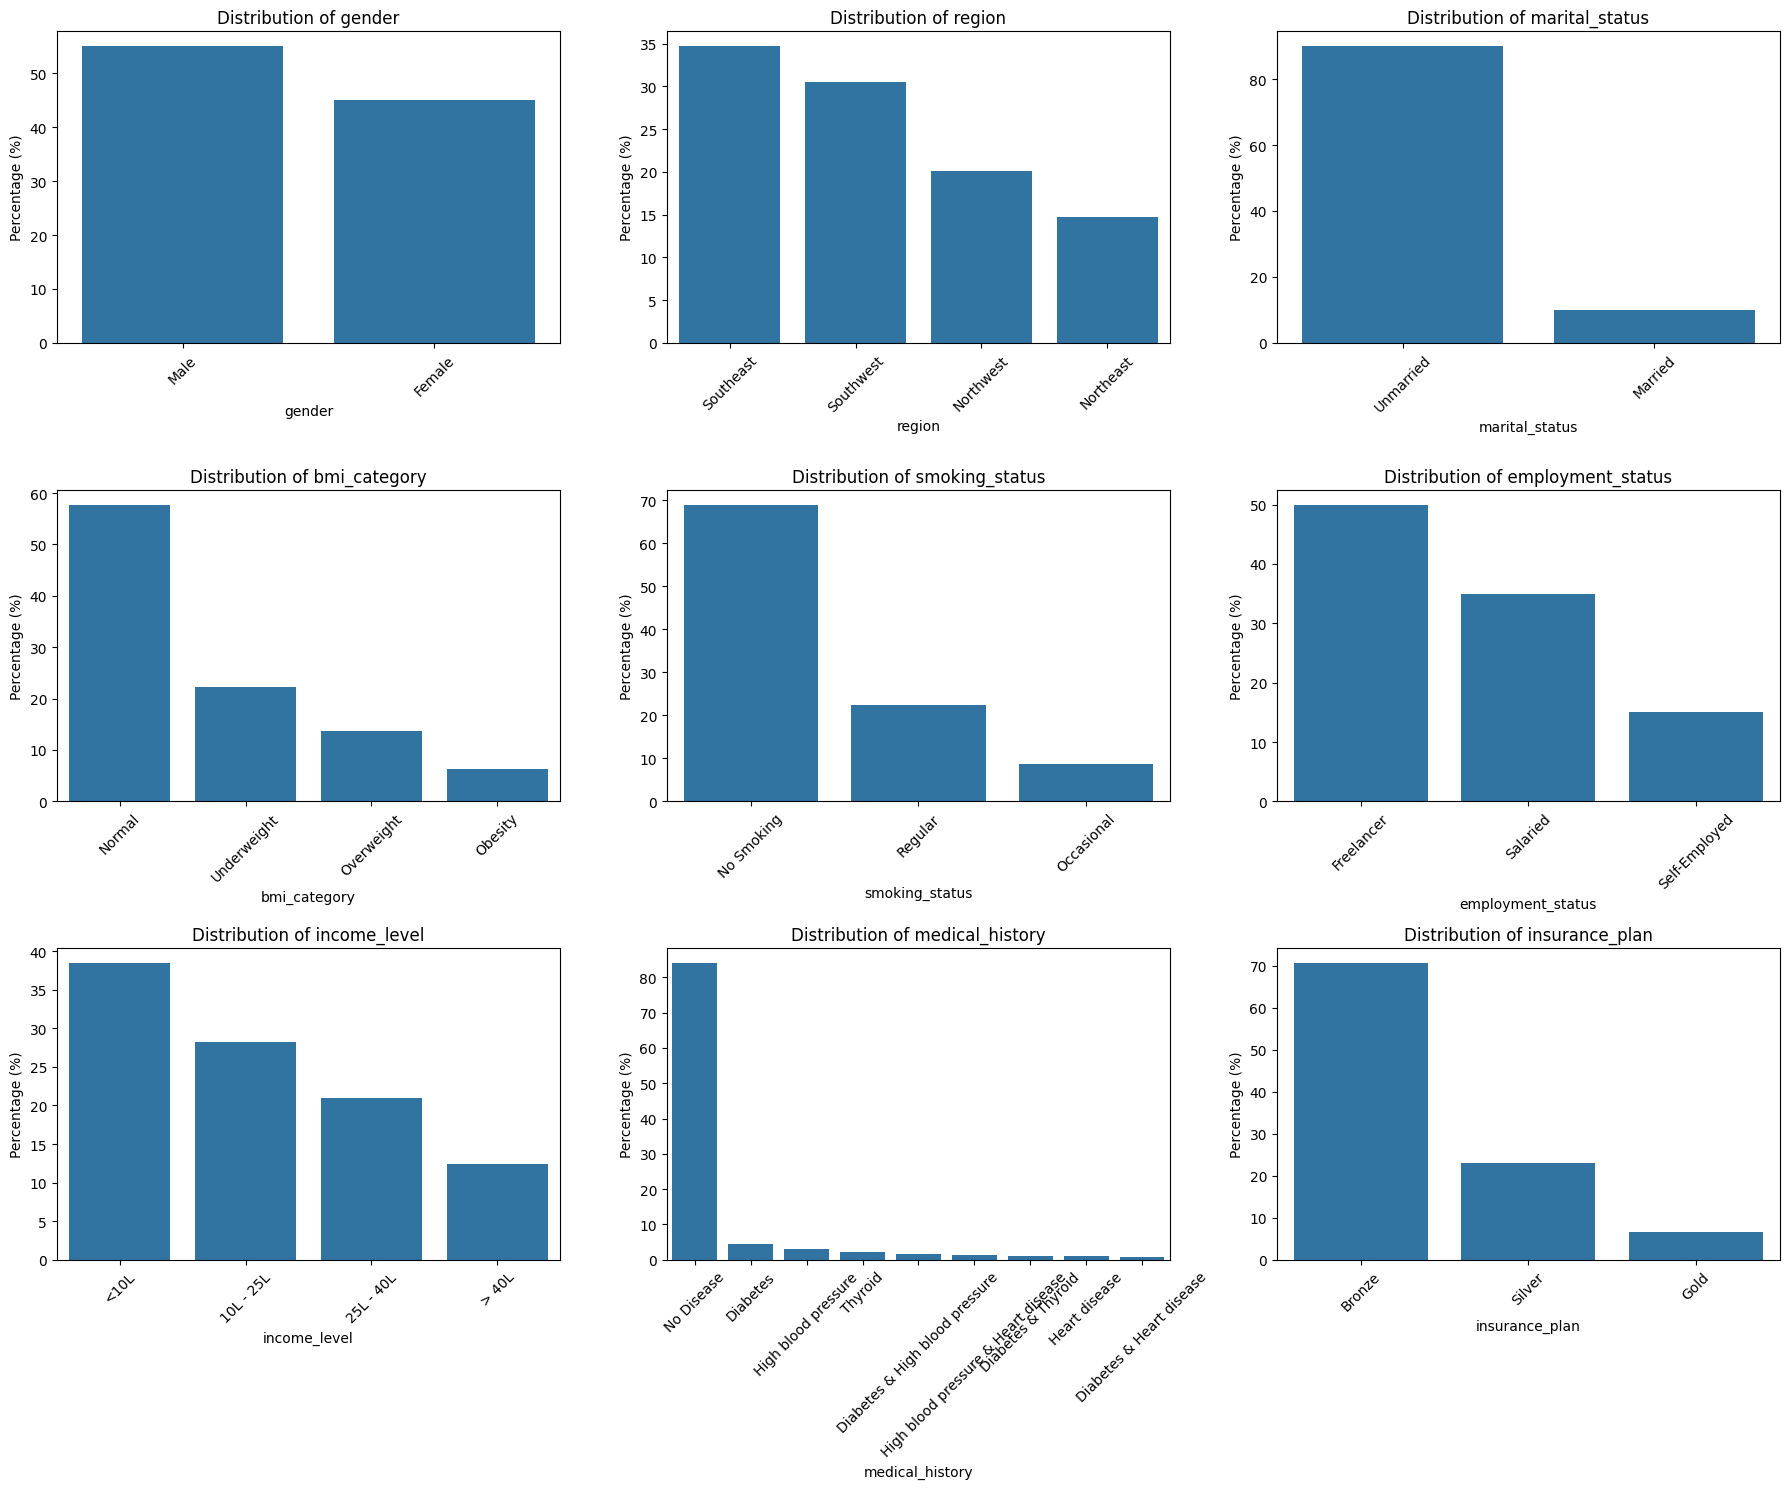

In [101]:






fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()


for i, col in enumerate(category_col[:9]):
    overall_pct = df2[col].value_counts(normalize=True) * 100
    
    
    sns.barplot(
    x=overall_pct.index,
    y=overall_pct.values,
    ax=axes[i]
    )
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Percentage (%)")
    axes[i].tick_params(axis='x', rotation=45)
    
    
plt.tight_layout()
plt.show()

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         4508   326     828
25L - 40L         3382   209     608
<10L              6172   404    1145
> 40L              115   366    2023


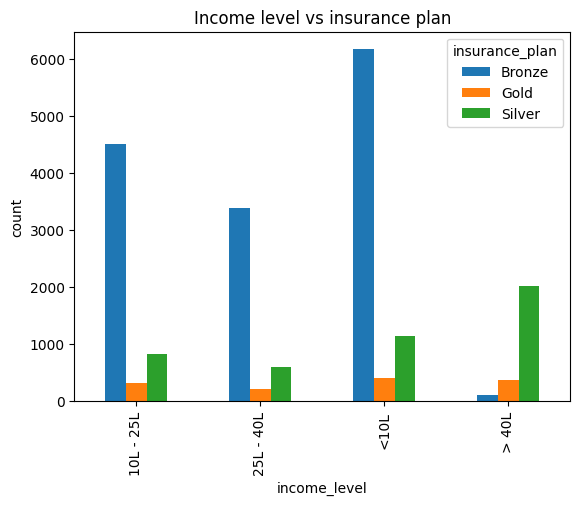

In [102]:
crosstab = pd.crosstab(df2['income_level'] , df2['insurance_plan'])
print(crosstab)
crosstab.plot(kind = "bar")
plt.title("Income level vs insurance plan")
plt.ylabel("count")
plt.show()

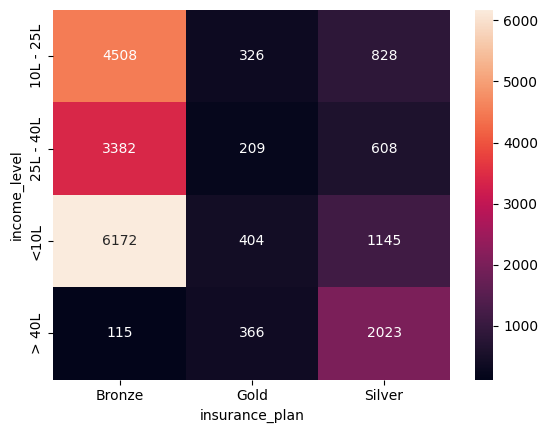

In [103]:
sns.heatmap(crosstab , fmt = "d" , annot = True)
plt.show()

### Feature Engineering

In [104]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050


In [105]:
df2.medical_history.unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

In [106]:
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

In [107]:
df2[['disease1', 'disease2']] = df2['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
df2['disease1'].fillna('none', inplace=True)
df2['disease2'].fillna('none', inplace=True)
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.head(15)


C:\Users\sehaj\AppData\Local\Temp\ipykernel_24860\1859339688.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['disease1'].fillna('none', inplace=True)
C:\Users\sehaj\AppData\Local\Temp\ipykernel_24860\1859339688.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,no disease,none,0,0.000000
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,no disease,none,0,0.000000
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,no disease,none,0,0.000000
5,22,Female,Southwest,Unmarried,0,Underweight,Regular,Freelancer,25L - 40L,30,High blood pressure,Gold,15473,high blood pressure,none,6,0.428571
6,19,Male,Southwest,Unmarried,0,Normal,No Smoking,Freelancer,<10L,8,No Disease,Bronze,4097,no disease,none,0,0.000000
7,18,Female,Northwest,Unmarried,1,Underweight,No Smoking,Salaried,<10L,5,Diabetes & High blood pressure,Bronze,8187,diabetes,high blood pressure,12,0.857143
8,23,Male,Northwest,Unmarried,0,Underweight,No Smoking,Salaried,<10L,8,No Disease,Bronze,5387,no disease,none,0,0.000000
9,20,Female,Northeast,Unmarried,0,Normal,Occasional,Salaried,10L - 25L,18,No Disease,Bronze,8866,no disease,none,0,0.000000


### Encode Text columns


In [108]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})
df2['insurance_plan']

0        2
1        2
2        2
3        1
4        1
        ..
20091    3
20092    3
20093    1
20094    1
20095    1
Name: insurance_plan, Length: 20086, dtype: int64

In [109]:
df2['income_level'] = df2['income_level'].map({'<10L':1, '10L - 25L': 2, '25L - 40L':3, '> 40L':4})
df2['income_level'].unique()

array([4, 1, 2, 3])

In [110]:
numeric_col = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2 , columns = numeric_col , drop_first = True , dtype = int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,High blood pressure,2,13365,high blood pressure,none,6,...,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,No Disease,2,11050,no disease,none,0,...,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,No Disease,2,11857,no disease,none,0,...,1,0,1,0,0,0,0,1,1,0
3,25,0,2,15,No Disease,1,5684,no disease,none,0,...,1,0,1,0,0,0,0,0,0,0
4,20,2,2,14,No Disease,1,5712,no disease,none,0,...,1,0,1,0,1,0,0,0,0,0


In [111]:
df4 = df3.drop(["medical_history" , "disease1" , "disease2" , "total_risk_score"] , axis =  1)
df4.head(3)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,2,11857,0.000000,0,0,1,0,1,0,0,0,0,1,1,0


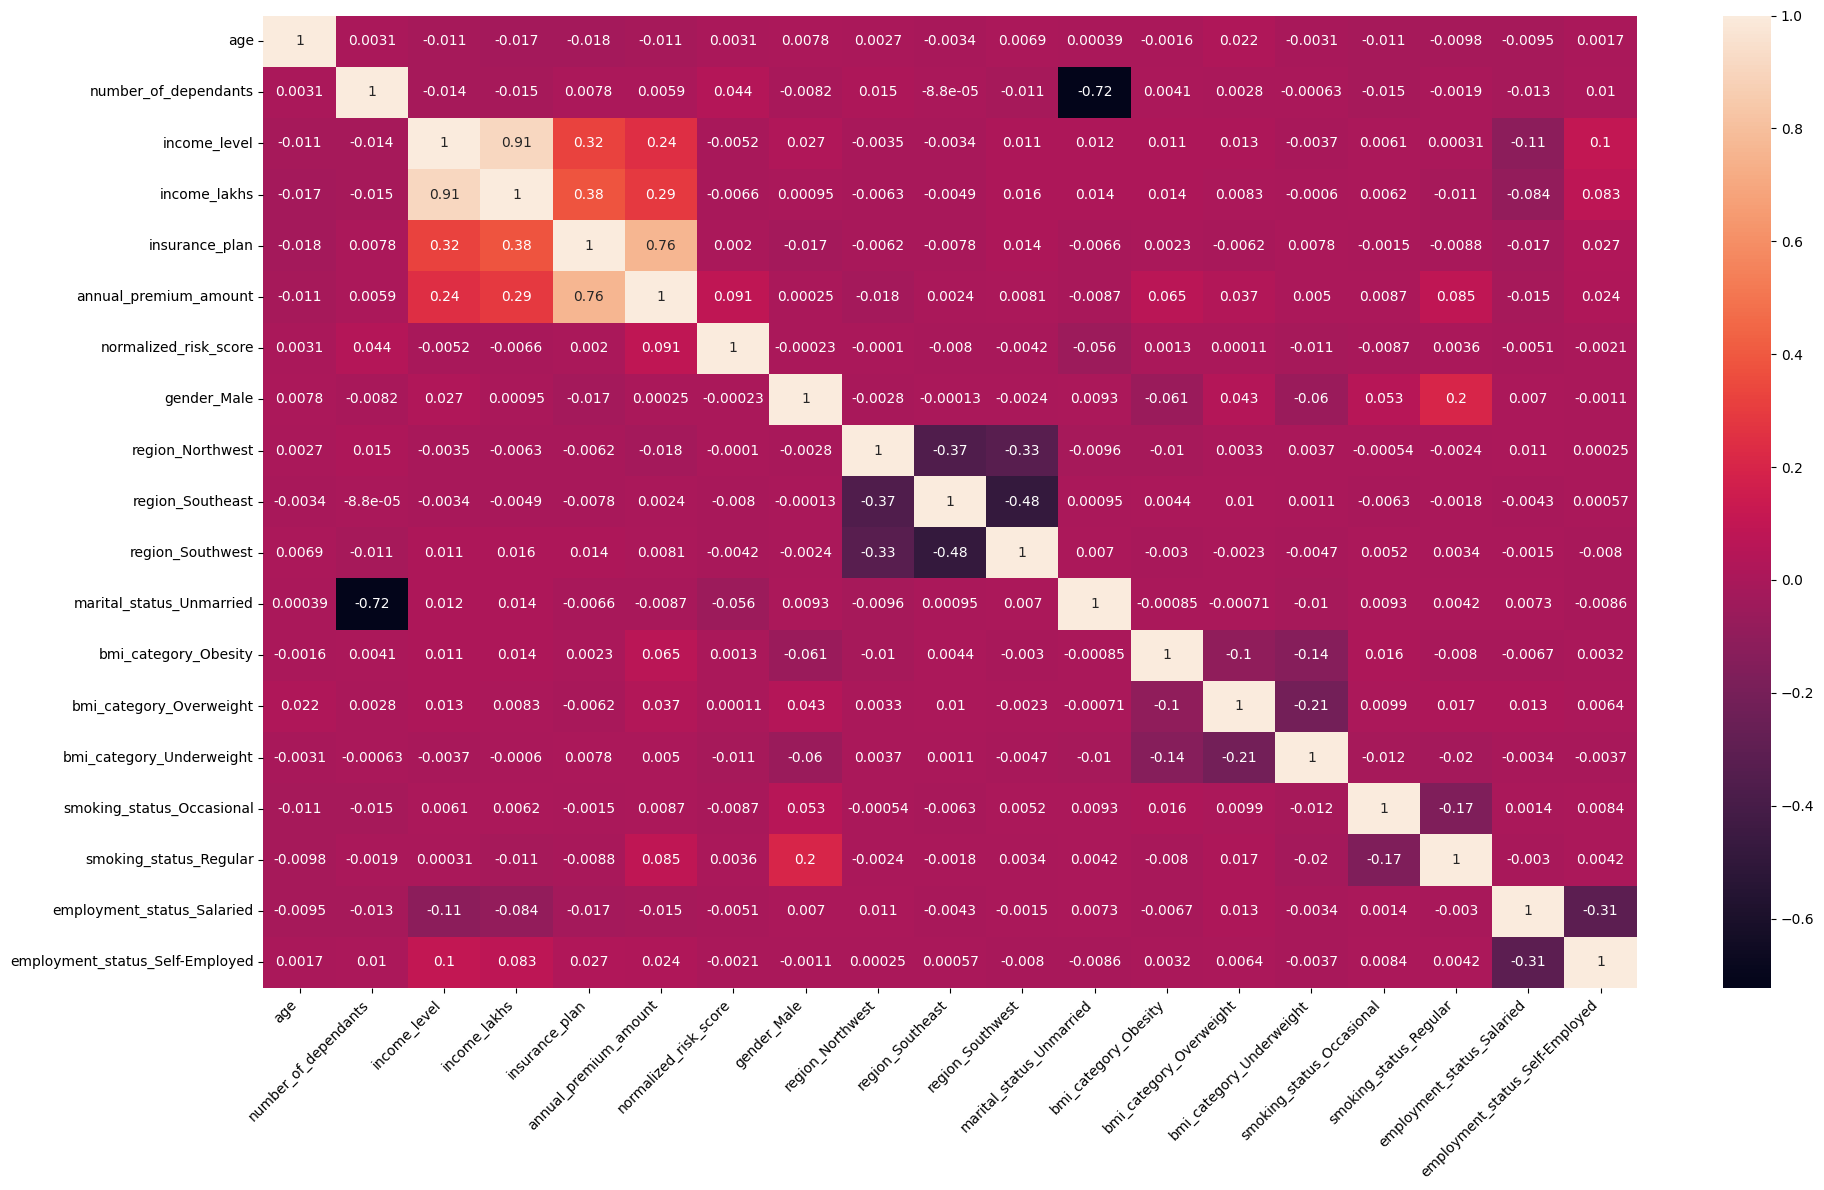

In [112]:
corr_mat = df4.corr()
plt.figure(figsize=(20,12))
sns.heatmap(corr_mat , annot = True)
plt.xticks(rotation = 45 , ha ='right')
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()

In [113]:
x = df4.drop("annual_premium_amount" , axis =1)
y = df4["annual_premium_amount"]

scaler = MinMaxScaler()
cols_to_scale = ["age" , "number_of_dependants" , "income_level" , "income_lakhs" , "insurance_plan"]
x[cols_to_scale] = scaler.fit_transform(x[cols_to_scale])
x.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,0.499211,0.240914,0.357994,0.216064,0.179578,0.092076,0.550383,0.201284,0.346958,0.304590,0.899881,0.063527,0.136513,0.222493,0.086379,0.223589,0.350045,0.149955
std,0.327750,0.312413,0.347481,0.219516,0.300051,0.230016,0.497467,0.400970,0.476014,0.460245,0.300167,0.243914,0.343341,0.415931,0.280929,0.416660,0.476996,0.357036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.000000,0.050505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.571429,0.000000,0.333333,0.151515,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.714286,0.333333,0.666667,0.303030,0.500000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [114]:
def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df


In [115]:
calculate_vif(x)

,Column,VIF
0,age,3.142881
1,number_of_dependants,1.860761
2,income_level,11.928707
3,income_lakhs,11.874242
4,insurance_plan,1.592892
5,normalized_risk_score,1.154223
6,gender_Male,2.310023
7,region_Northwest,2.147701
8,region_Southeast,2.970188
9,region_Southwest,2.730503


In [116]:
calculate_vif(x.drop("income_level" , axis = 1))

,Column,VIF
0,age,3.141534
1,number_of_dependants,1.858110
2,income_lakhs,2.291873
3,insurance_plan,1.587794
4,normalized_risk_score,1.154174
5,gender_Male,2.299848
6,region_Northwest,2.146767
7,region_Southeast,2.968993
8,region_Southwest,2.729813
9,marital_status_Unmarried,7.299818


In [117]:
x_reduced =  x.drop("income_level" , axis =1)
x_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.000000,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.000000,0.020202,0.5,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,0.969697,0.5,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.000000,0.141414,0.0,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,0.285714,0.666667,0.131313,0.0,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


### Model Training

In [118]:
x_train , x_test , y_train, y_test = train_test_split(x_reduced , y , test_size = 0.3 , random_state = 10)

print("x_train:" , x_train.shape)
print("x_test:" , x_test.shape)
print("y_train:" , y_train.shape)
print("y_test:" , y_test.shape)


x_train: (14060, 17)
x_test: (6026, 17)
y_train: (14060,)
y_test: (6026,)


In [119]:
model_lr = LinearRegression()
model_lr.fit(x_train , y_train)

test_score = model_lr.score(x_test , y_test)
train_score = model_lr.score(x_train , y_train)

print("Test score of the linear regression :" , test_score)
print("Train score of the linear regression : " , train_score)

Test score of the linear regression : 0.6047589163893645
Train score of the linear regression :  0.6020471274164894


In [120]:
y_pred = model_lr.predict(x_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Linear Regression ==> MSE:  3005669.8791236714 RMSE:  1733.6867880686152


In [121]:
x_test.head(2)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
12774,1.000000,0.666667,0.040404,0.0,0.0,1,0,0,1,1,0,0,1,0,0,0,0
14758,0.285714,0.000000,0.060606,0.0,0.0,0,0,0,1,1,0,0,0,0,1,0,1


In [122]:
model_lr.intercept_

np.float64(6614.583391230755)

In [123]:
model_lr.coef_

array([ 5.51905147e+01, -1.45039643e+02, -3.60667677e+01,  7.00007042e+03,
        1.11127879e+03,  9.82564766e+00, -1.14273450e+02, -3.64663714e+01,
       -6.72232248e+01, -5.85343424e+01,  7.92952660e+02,  4.35760406e+02,
        1.69728916e+02,  2.44813937e+02,  6.19082947e+02, -1.30535485e+01,
       -4.34272200e+00])

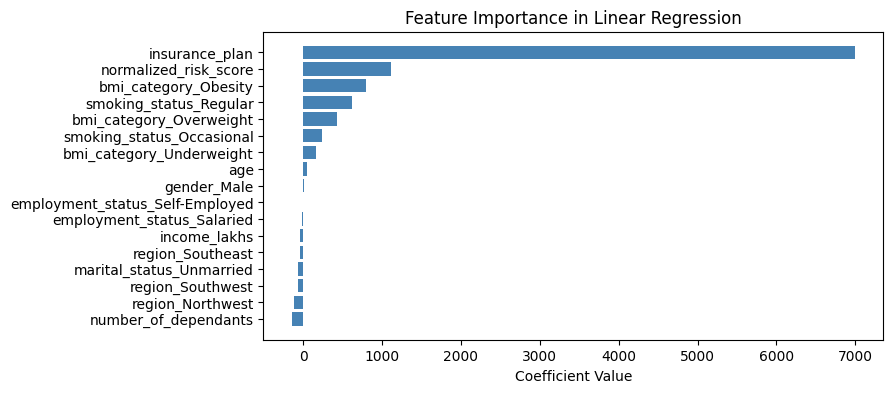

In [124]:
feature_importance = model_lr.coef_
coef_df = pd.DataFrame(feature_importance , index = x_test.columns , columns = ["coefficients"])
coef_df = coef_df.sort_values(by ="coefficients" , ascending= True)
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

In [125]:
model_ridge = Ridge()
model_ridge.fit(x_train , y_train)
test_score_ridge = model_ridge.score(x_test , y_test)
train_score_ridge = model_ridge.score(x_train , y_train)
print("Test score of the Ridge model is :" , test_score_ridge)
print("Train score of the Ridge model is :" , train_score_ridge)

Test score of the Ridge model is : 0.6047715291063815
Train score of the Ridge model is : 0.6020466631305188


In [126]:
model_xgb = XGBRegressor()
model_xgb.fit(x_train , y_train)
test_score_xgb = model_xgb.score(x_test , y_test)
train_score_xgb = model_xgb.score(x_train , y_train)
print("Test score of the xgb model is :" , test_score_xgb)
print("Train score of the xgb model is :" , train_score_xgb)

Test score of the xgb model is : 0.5638787746429443
Train score of the xgb model is : 0.7251046895980835


In [127]:
y_pred = model_xgb.predict(x_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("XGBoost Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

XGBoost Regression ==> MSE:  3316548.97851731 RMSE:  1821.1394725603282


In [128]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(x_train, y_train)
random_search.best_score_

np.float64(0.5997088948885599)

In [129]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}

In [130]:
best_model = random_search.best_estimator_
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50,
             n_jobs=None, num_parallel_tree=None, ...)

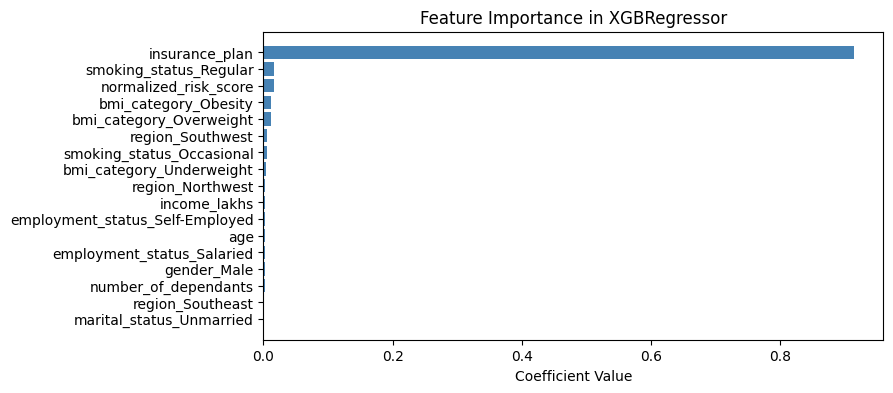

In [131]:
feature_importance = best_model.feature_importances_
coef_df = pd.DataFrame(feature_importance , index = x_test.columns , columns = ["coefficients"])
coef_df = coef_df.sort_values(by ="coefficients" , ascending= True)
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBRegressor')
plt.show()

### Error Analysis

In [132]:
y_pred = best_model.predict(x_test)
residuals = y_pred - y_test
residuals_pct = residuals*100/y_test

results_df = pd.DataFrame({
    'actual': y_test ,
    'predicted' : y_pred ,
    'diff' : residuals ,
    'diff_pct' : residuals_pct
})

results_df.head()

,actual,predicted,diff,diff_pct
12774,6238,6669.329590,431.329590,6.914549
14758,9462,6999.429199,-2462.570801,-26.025902
13205,5152,6998.085449,1846.085449,35.832404
14278,6988,7868.310059,880.310059,12.597454
19351,4917,6677.658203,1760.658203,35.807570


<Axes: xlabel='diff_pct', ylabel='Count'>

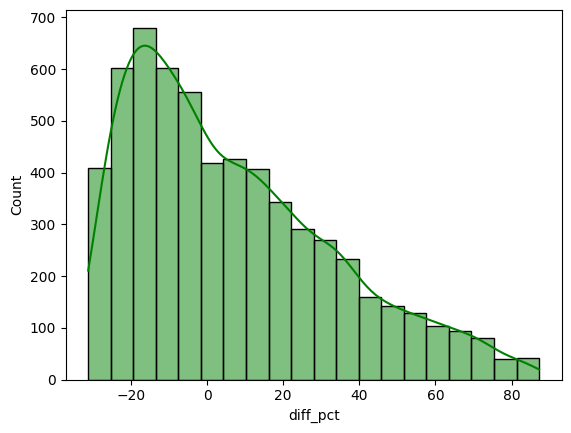

In [133]:
sns.histplot(results_df['diff_pct'] , bins = 20 , color = 'green' , edgecolor = 'black' , kde = True)


In [134]:
extreme_error_threshold = 10
extreme_results_df = results_df[np.abs(results_df['diff_pct']) > extreme_error_threshold]
extreme_results_df 


,actual,predicted,diff,diff_pct
14758,9462,6999.429199,-2462.570801,-26.025902
13205,5152,6998.085449,1846.085449,35.832404
14278,6988,7868.310059,880.310059,12.597454
19351,4917,6677.658203,1760.658203,35.807570
10622,8947,7154.854492,-1792.145508,-20.030686
...,...,...,...,...
399,8673,7575.317871,-1097.682129,-12.656314
17652,7635,6585.947754,-1049.052246,-13.740043
5807,4845,7057.350098,2212.350098,45.662541
10298,13866,10994.864258,-2871.135742,-20.706301


In [135]:
results_df.shape

(6026, 4)

In [136]:
extreme_results_df.shape

(4407, 4)

In [137]:
extreme_error_pct = extreme_results_df.shape[0] *100 / results_df.shape[0]
extreme_error_pct

73.13308994357783

In [138]:
results_df[np.abs(results_df['diff_pct']) > 50].sort_values('diff_pct' , ascending = False)

,actual,predicted,diff,diff_pct
4169,3517,6584.604004,3067.604004,87.222178
4692,3516,6572.262207,3056.262207,86.924409
12285,3532,6585.947754,3053.947754,86.465112
3652,3536,6585.947754,3049.947754,86.254179
16580,3538,6585.947754,3047.947754,86.148891
...,...,...,...,...
405,4659,6999.680176,2340.680176,50.239969
3032,4388,6585.947754,2197.947754,50.089967
44,4389,6584.604004,2195.604004,50.025154
15383,4390,6585.947754,2195.947754,50.021589


In [139]:
x_test.index

Index([12774, 14758, 13205, 14278, 19351, 10622, 16391, 14799, 17184, 16348,
       ...
        8695,  9658, 14195,  1365,   399, 17652,  5807, 10298, 13316,  2583],
      dtype='int64', length=6026)

In [140]:
extreme_results_df.index

Index([14758, 13205, 14278, 19351, 10622, 14799, 16348,  5573,  5634, 14882,
       ...
        5484,  8988,  8695,  9658,  1365,   399, 17652,  5807, 10298, 13316],
      dtype='int64', length=4407)

In [141]:
extreme_error_df = x_test.loc[extreme_results_df.index]
extreme_error_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
14758,0.285714,0.000000,0.060606,0.0,0.000000,0,0,0,1,1,0,0,0,0,1,0,1
13205,0.714286,0.333333,0.141414,0.0,0.000000,1,1,0,0,1,0,0,0,0,1,0,1
14278,0.714286,0.333333,0.222222,0.0,0.000000,1,0,1,0,1,1,0,0,0,1,0,0
19351,0.571429,0.000000,0.101010,0.0,0.000000,1,0,0,1,1,0,0,1,0,0,0,0
10622,0.428571,0.333333,0.050505,0.0,0.357143,0,0,1,0,1,0,1,0,0,0,0,0


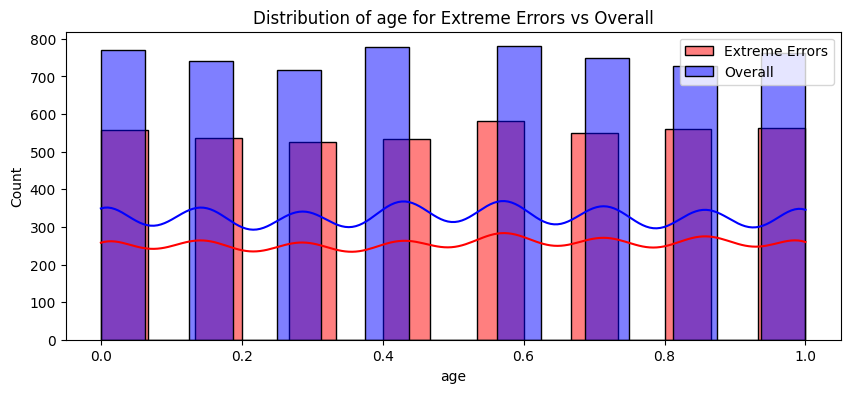

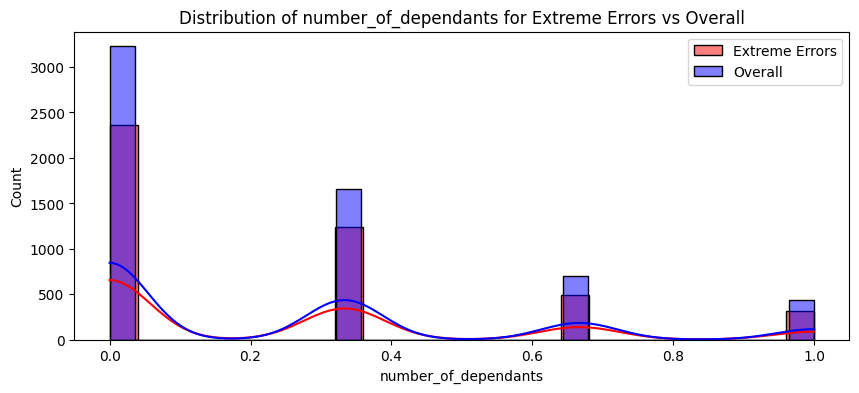

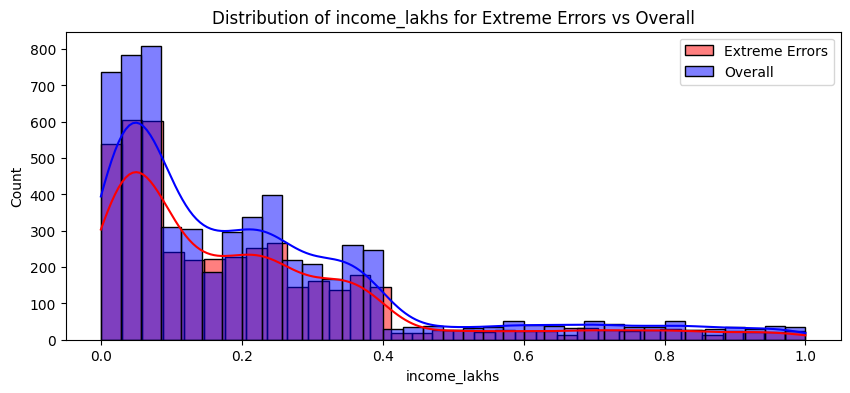

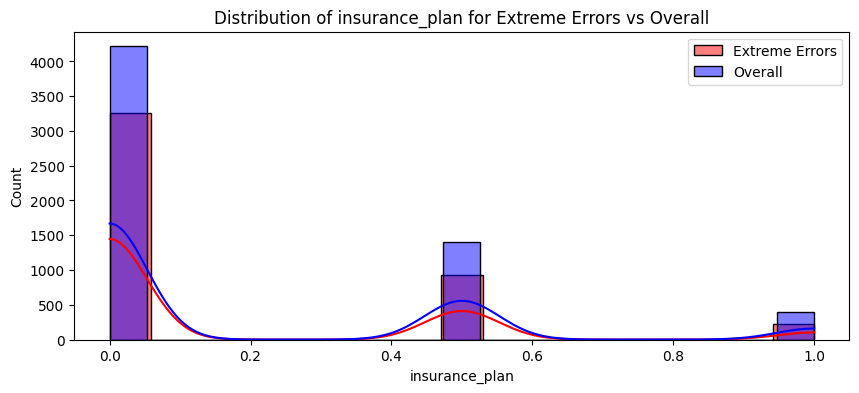

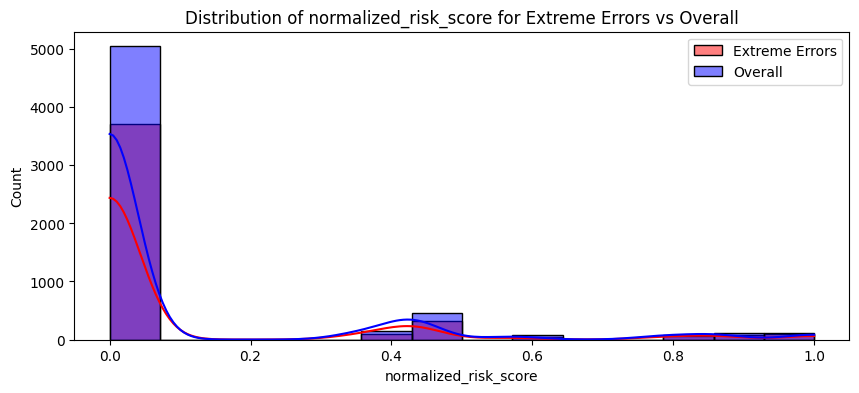

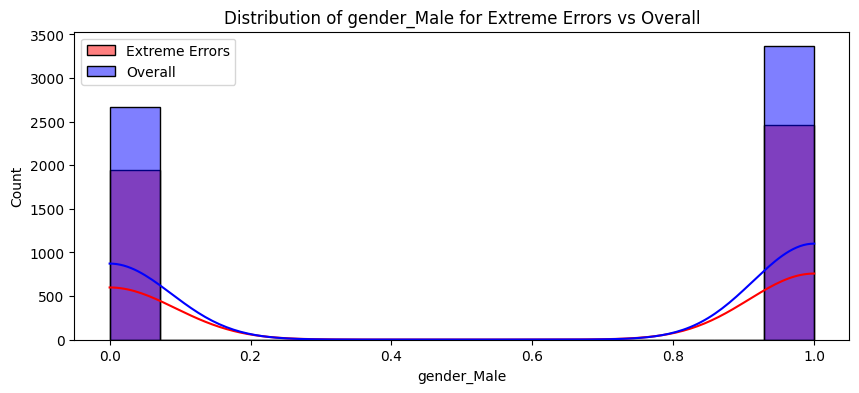

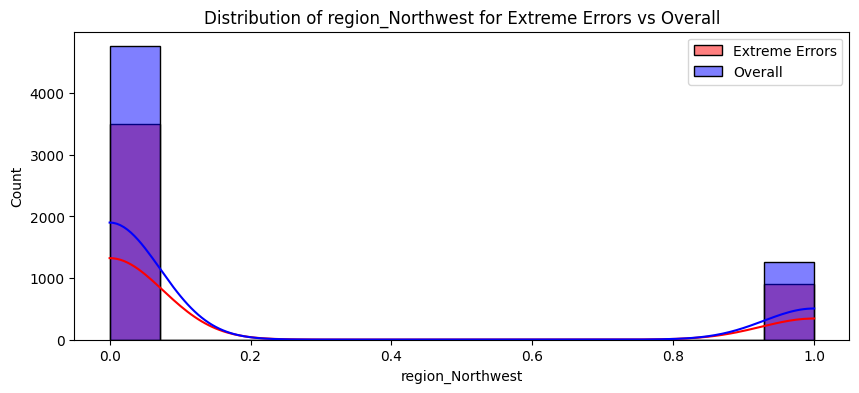

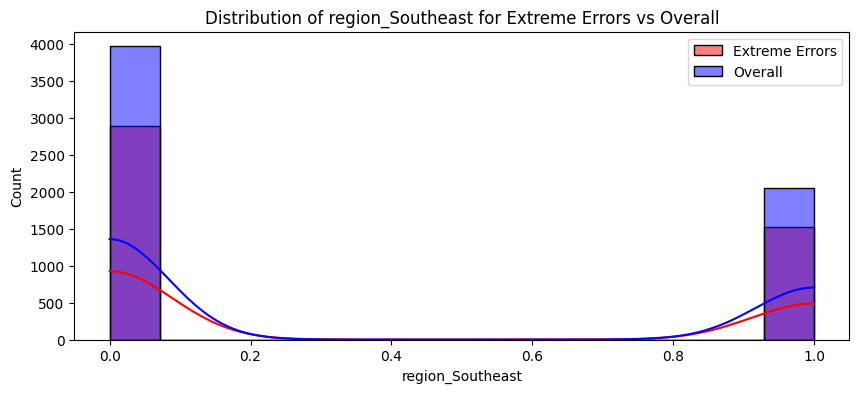

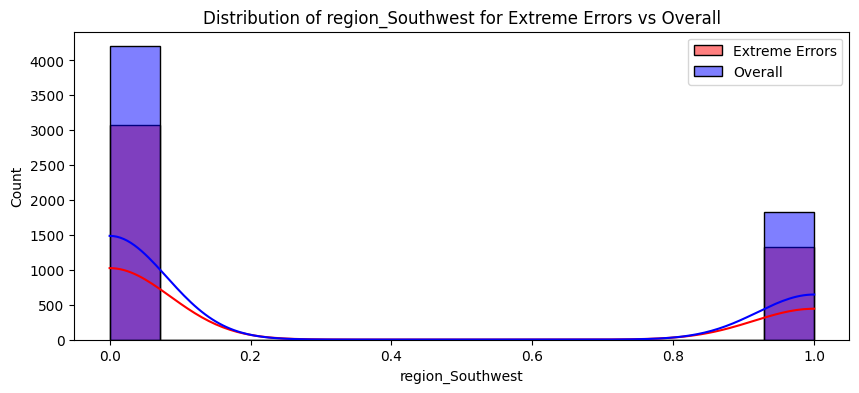

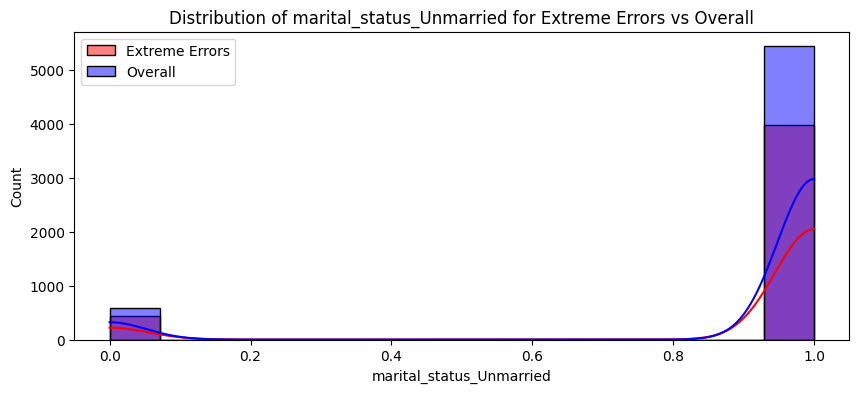

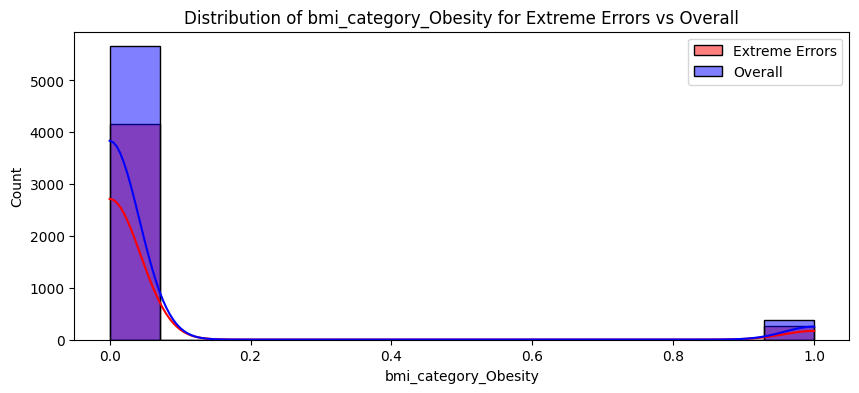

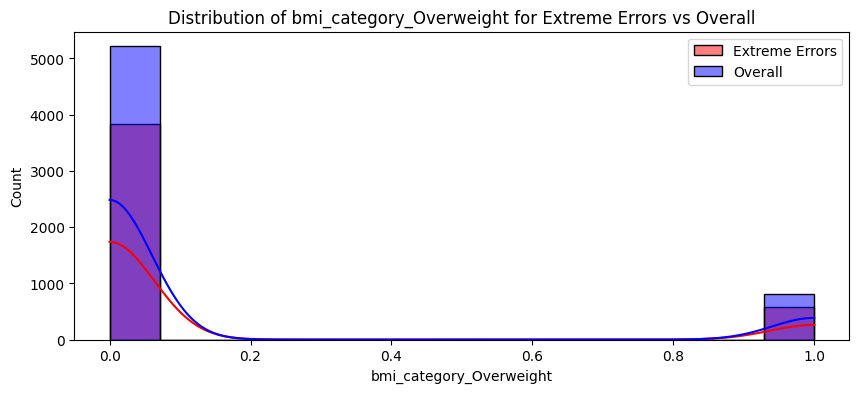

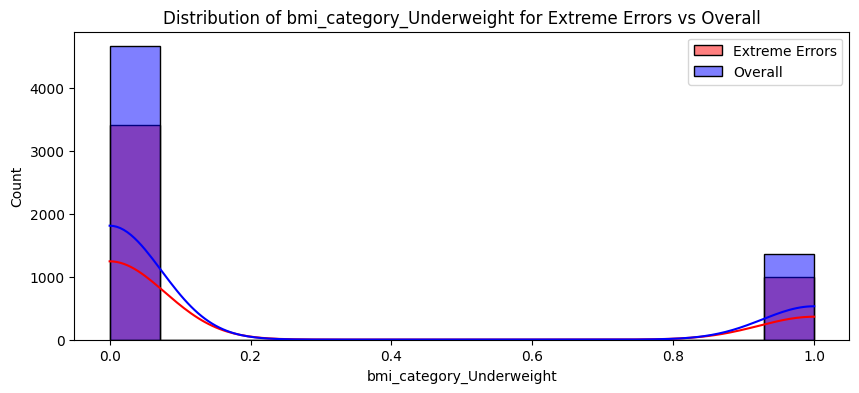

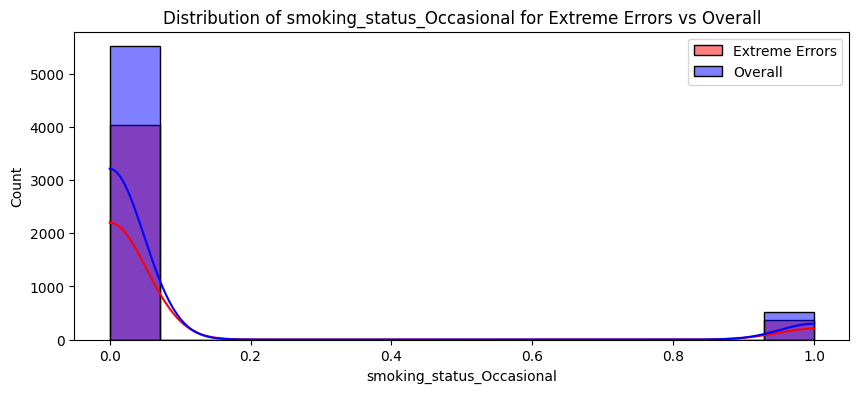

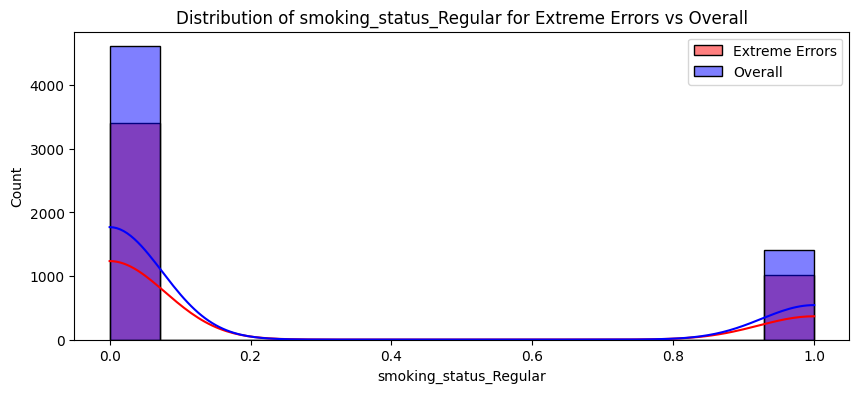

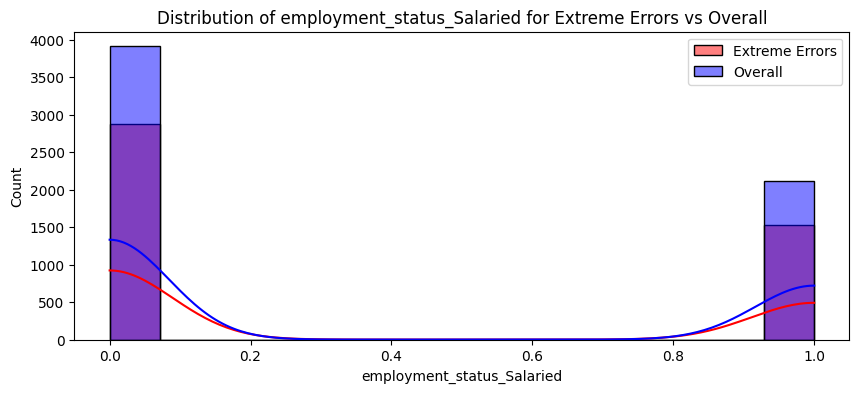

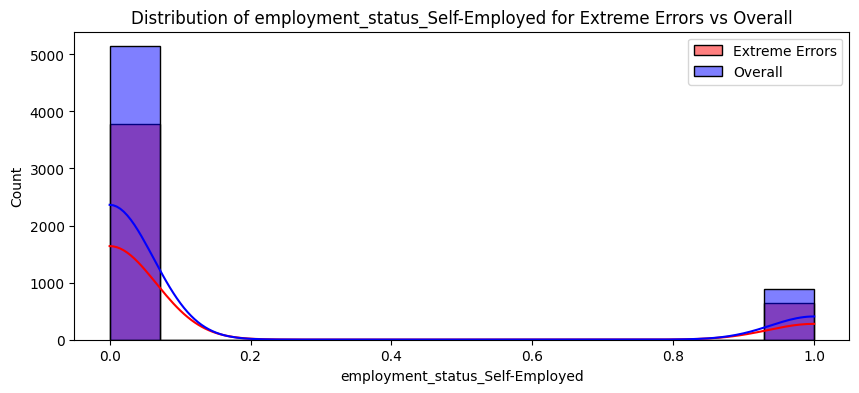

In [142]:
for feature in x_test.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(extreme_error_df[feature], color='red', label='Extreme Errors', kde=True)
    sns.histplot(x_test[feature], color='blue', label='Overall', alpha=0.5, kde=True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.show()


### Problem in Age column

In [143]:
cols_to_scale

['age',
 'number_of_dependants',
 'income_level',
 'income_lakhs',
 'insurance_plan']

In [144]:
extreme_error_df['income_level'] = -1

<Axes: xlabel='age', ylabel='Count'>

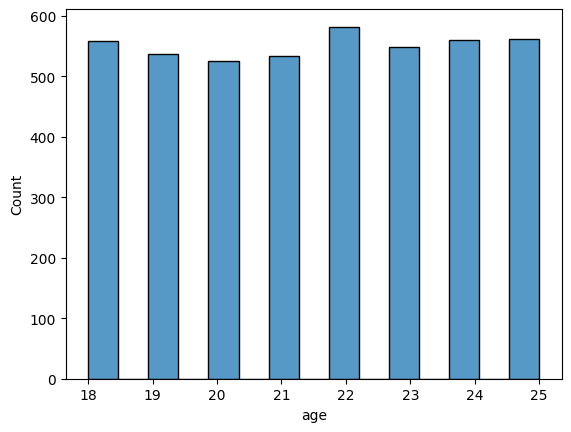

In [145]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_error_df[cols_to_scale])
df_reversed.head()
sns.histplot(df_reversed["age"])

In [146]:
### This means that 97% of age is 25 .

df_reversed["age"].quantile(0.97)

np.float64(25.0)